In [30]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

In [31]:
kt = KaTrainBase(force_package_config=True)

In [32]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1 # super quick - maybe inaccurate
e_config["threads"] = 72
e_config["config"] = "./kata_config.cfg"
e_config

{'katago': '',
 'model': 'katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz',
 'config': './kata_config.cfg',
 'threads': 72,
 'max_visits': 1,
 'fast_visits': 1,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True}

In [33]:
engine = KataGoEngine(kt, e_config)

2020-06-15 16:45:44+0200: Analysis Engine starting...
2020-06-15 16:45:44+0200: KataGo v1.4.2+kt1.1 (minified)
2020-06-15 16:45:44+0200: nnRandSeed0 = 12977088500320358533
2020-06-15 16:45:44+0200: After dedups: nnModelFile0 = /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz useFP16 auto useNHWC auto


In [34]:
PLAYERS={'W':'white','B':'black'}

def get_move_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    b_scoreloss = [move.points_lost for move in moves]
    
    
    num_legal_moves = [sum(pv >= 0 for pv,_ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num+1, num_mv, rank, value, policy_ranking[0][0], move.score, move.points_lost, PLAYERS[mv.player]) 
        for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

def normalized_histogram(data, **args):
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, **args)

def analyze_game(filename):
    sgf = KaTrainSGF.parse_file(filename)
    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']
    if sgf.board_size!=(19,19):
        skipped['board_size'][sgf.board_size] += 1
        return

    if outcome == 'Cancellation':
        skipped['cancelled'] += 1
        return

    if len(gamedata['moves']) < MIN_MOVES:
        skipped['min_moves'] += 1
        return


    if 'active_game' in gamedata and gamedata['active_game'][non_bot_player]['ratings']['overall']['deviation'] > MAX_DEVIATION:
        skipped['provisional'] += 1
        return

    try:
        game = Game(kt, engine, move_tree=sgf)
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_move_stats(game) ] 
    except Exception as e:
        print(f"Error in analyzing {filename}: {e}") # branching etc
        return

    return gameid, (filename, players[bot_player],rank[bot_player], players[non_bot_player],
            rank[non_bot_player],non_bot_player, winner,outcome,gamedata['ranked']), move_analysis

2020-06-15 16:45:45+0200: Found OpenCL Platform 0: NVIDIA CUDA (NVIDIA Corporation) (OpenCL 1.2 CUDA 10.2.131)
2020-06-15 16:45:45+0200: Found 1 device(s) on platform 0 with type CPU or GPU or Accelerator
2020-06-15 16:45:45+0200: Found OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) (score 11000102)
2020-06-15 16:45:45+0200: Using OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) OpenCL 1.2 CUDA
2020-06-15 16:45:45+0200: Loaded tuning parameters from: /home/sander/.katrain/opencltuning/tune6_gpuGeForceGTX1050TiwithMaxQDesign_x19_y19_c192_mv8.txt
2020-06-15 16:45:45+0200: Loaded config /home/sander/Desktop/toy/katrain-bots/kata_config.cfg
2020-06-15 16:45:45+0200: Loaded model /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz
2020-06-15 16:45:45+0200: OpenCL backend: Model version 8
2020-06-15 16:45:45+0200: OpenCL backend: Model name: g170-b15c192-s1672170752-d466197061
20

In [35]:
analyze_games = False
MAX_DEVIATION = 175 # exclude players with a non-established rank
MIN_MOVES = 100 # exclude games with < this many moves

In [86]:
if analyze_games:
    from multiprocessing.pool import ThreadPool
    import threading
    
    games_data = pd.DataFrame(columns=['file','bot','bot_rank','user','user_rank','user_color','winner','outcome','ranked'])
    moves_data = []
    skipped = defaultdict(int)
    skipped['board_size'] = defaultdict(int)
    
    files = glob.glob("sgf_ogs/*.sgf")
    pbar = tqdm(total=len(files))
    lock = threading.Lock()

    def process_file(filename):
        result = analyze_game(filename)
        pbar.update(1)
        if result:
            gameid, gamedata_row, move_analysis = result
            with lock:
                games_data.loc[gameid] = gamedata_row
                moves_data.append(move_analysis)            
            
            
    pool = ThreadPool(8)
    pool.map(process_file, files)
    pbar.close()
    
    moves_data = pd.DataFrame( sum(moves_data,[]),    
        columns=['game_id','move','num_legal','policy_rank','policy_value','top_value',
                 'black_score','points_lost','move_color','user_color'])

    games_data.to_csv('games.csv.gz',compression='gzip')
    moves_data.to_csv('moves.csv.gz',compression='gzip')
    print(f"{games_data.shape[0]} games and {moves_data.shape[0]} moves analyzed.\nGames skipped: {dict(skipped)}")
else:
    moves_data = pd.read_csv('moves.csv.gz',index_col=0)
    games_data = pd.read_csv('games.csv.gz',index_col=0)
    print(f"Loaded {games_data.shape[0]} games and {moves_data.shape[0]} moves.")    

Loaded 2140 games and 580378 moves.


In [84]:
plt.rcParams.update({'font.size': 22})

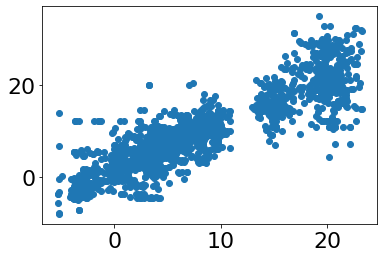

In [85]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

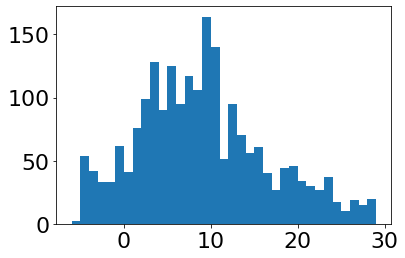

In [11]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [12]:
moves_data = moves_data.loc[moves_data.game_id.map(lambda x: x in games_data.index)] # race cond?

In [13]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color]
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

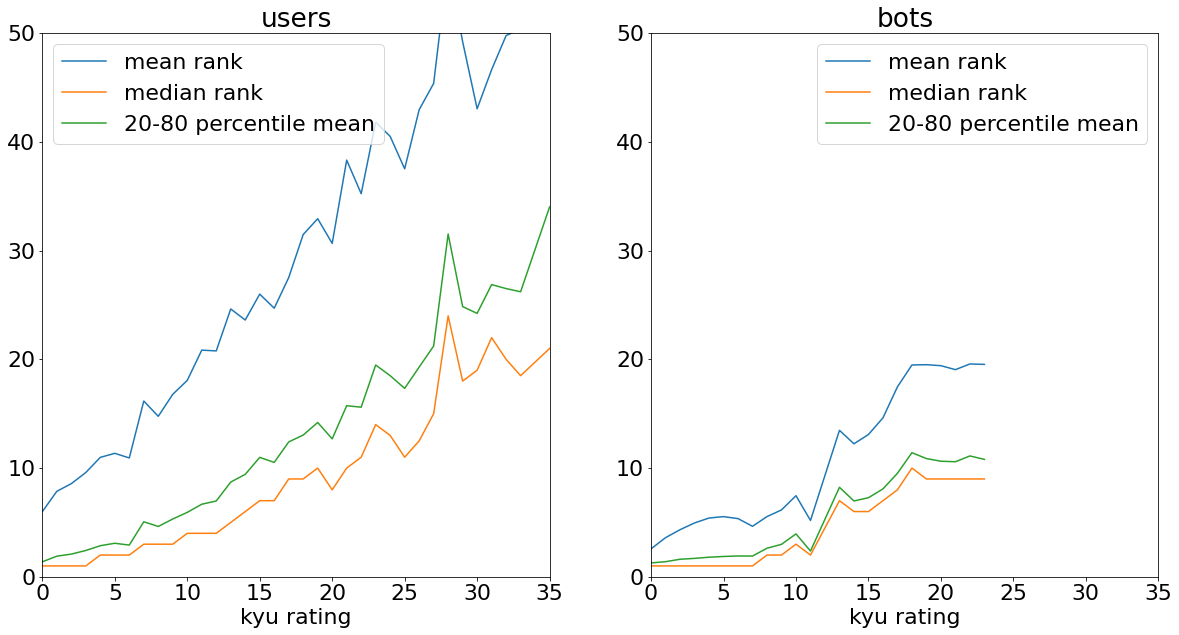

In [14]:
plt.figure(figsize=(20,10))
for i,moves in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in moves.groupby(moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])
    plt.ylim([0,50])
    plt.xlim([0,35])

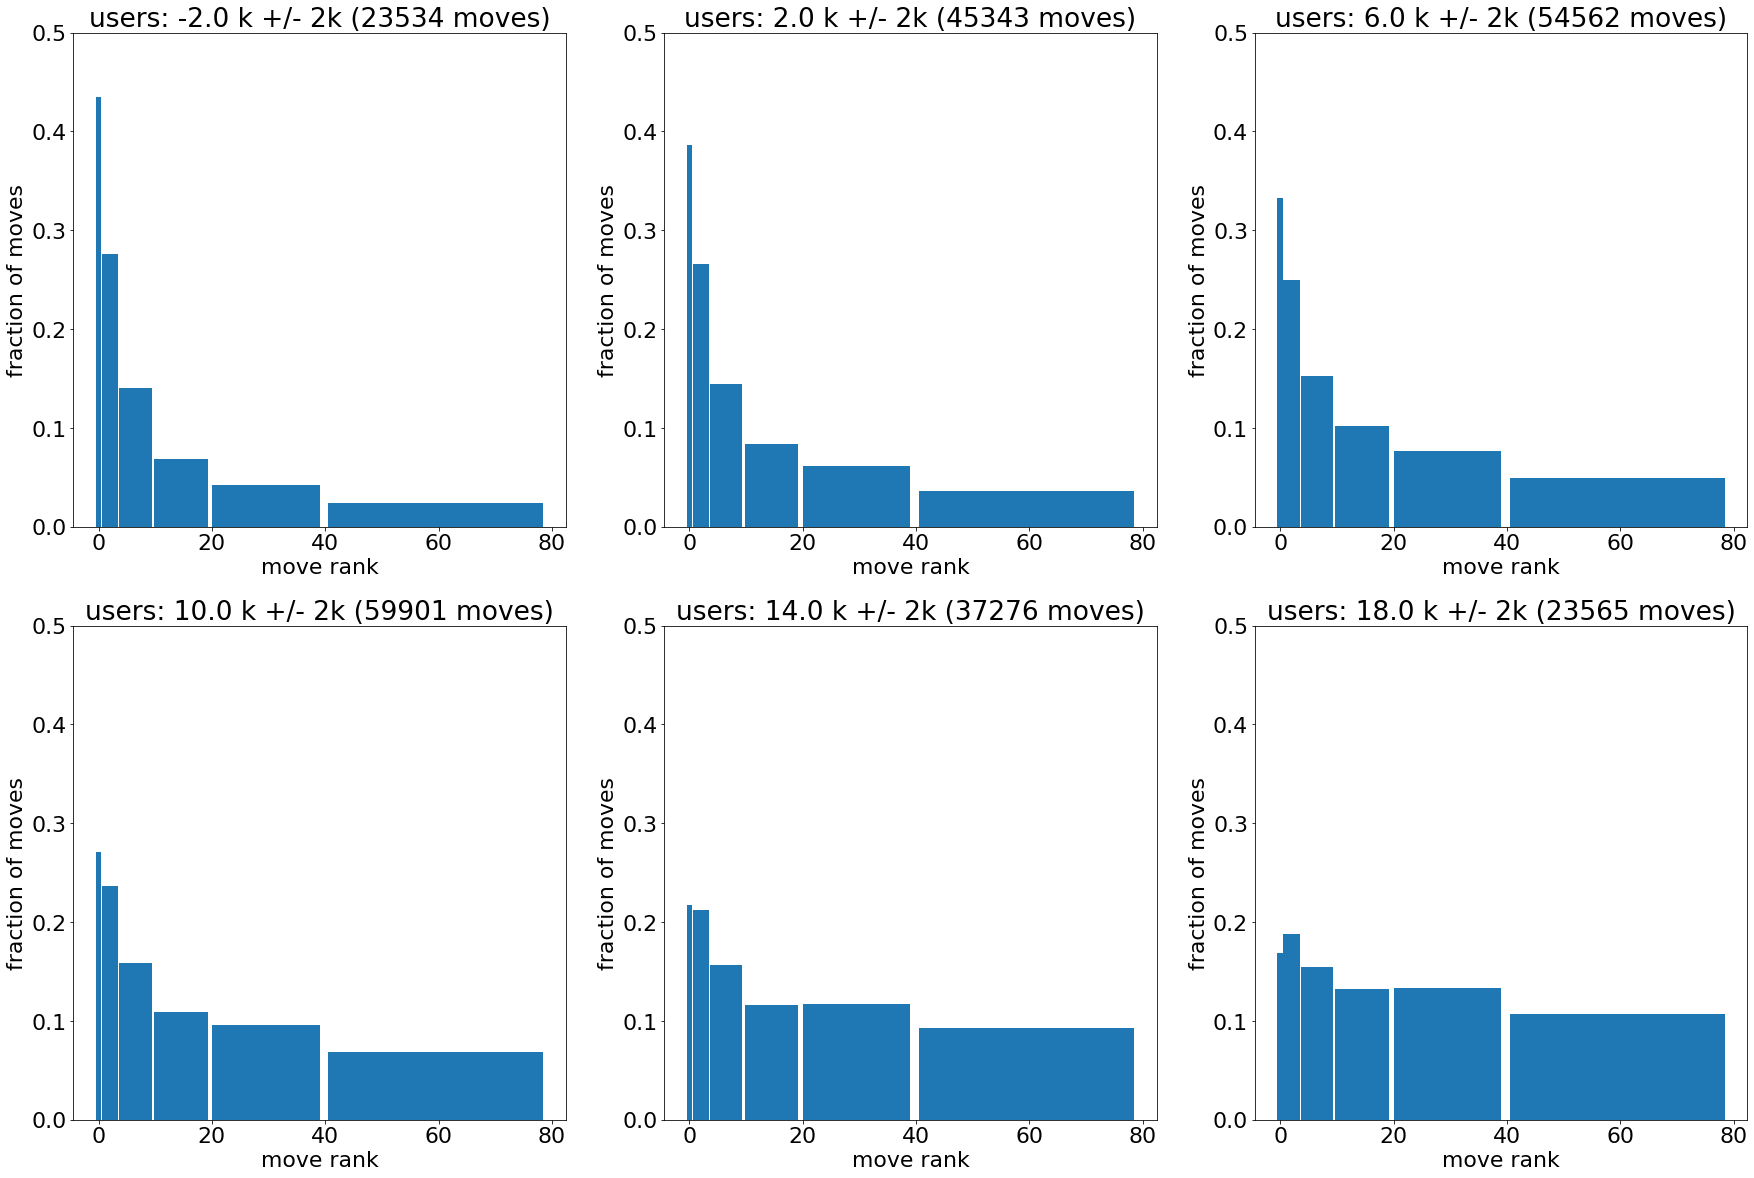

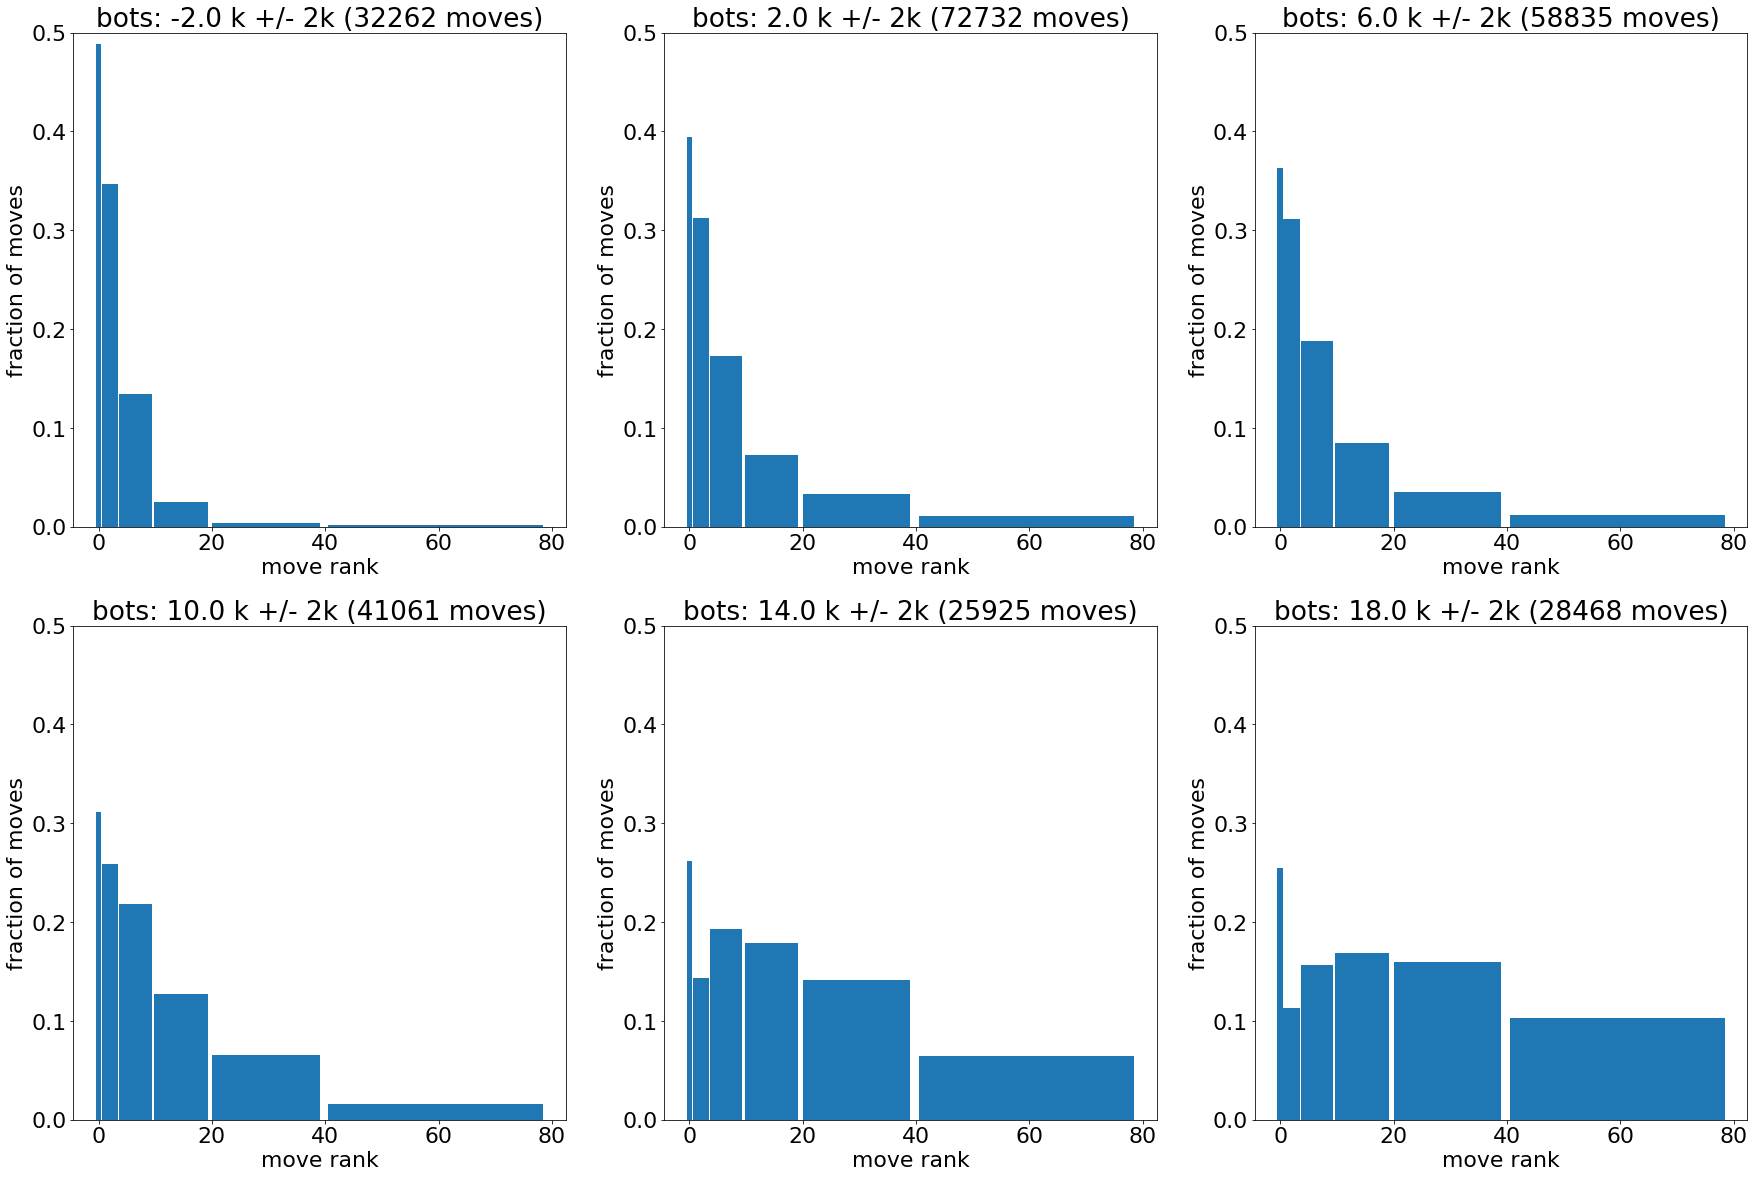

In [15]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

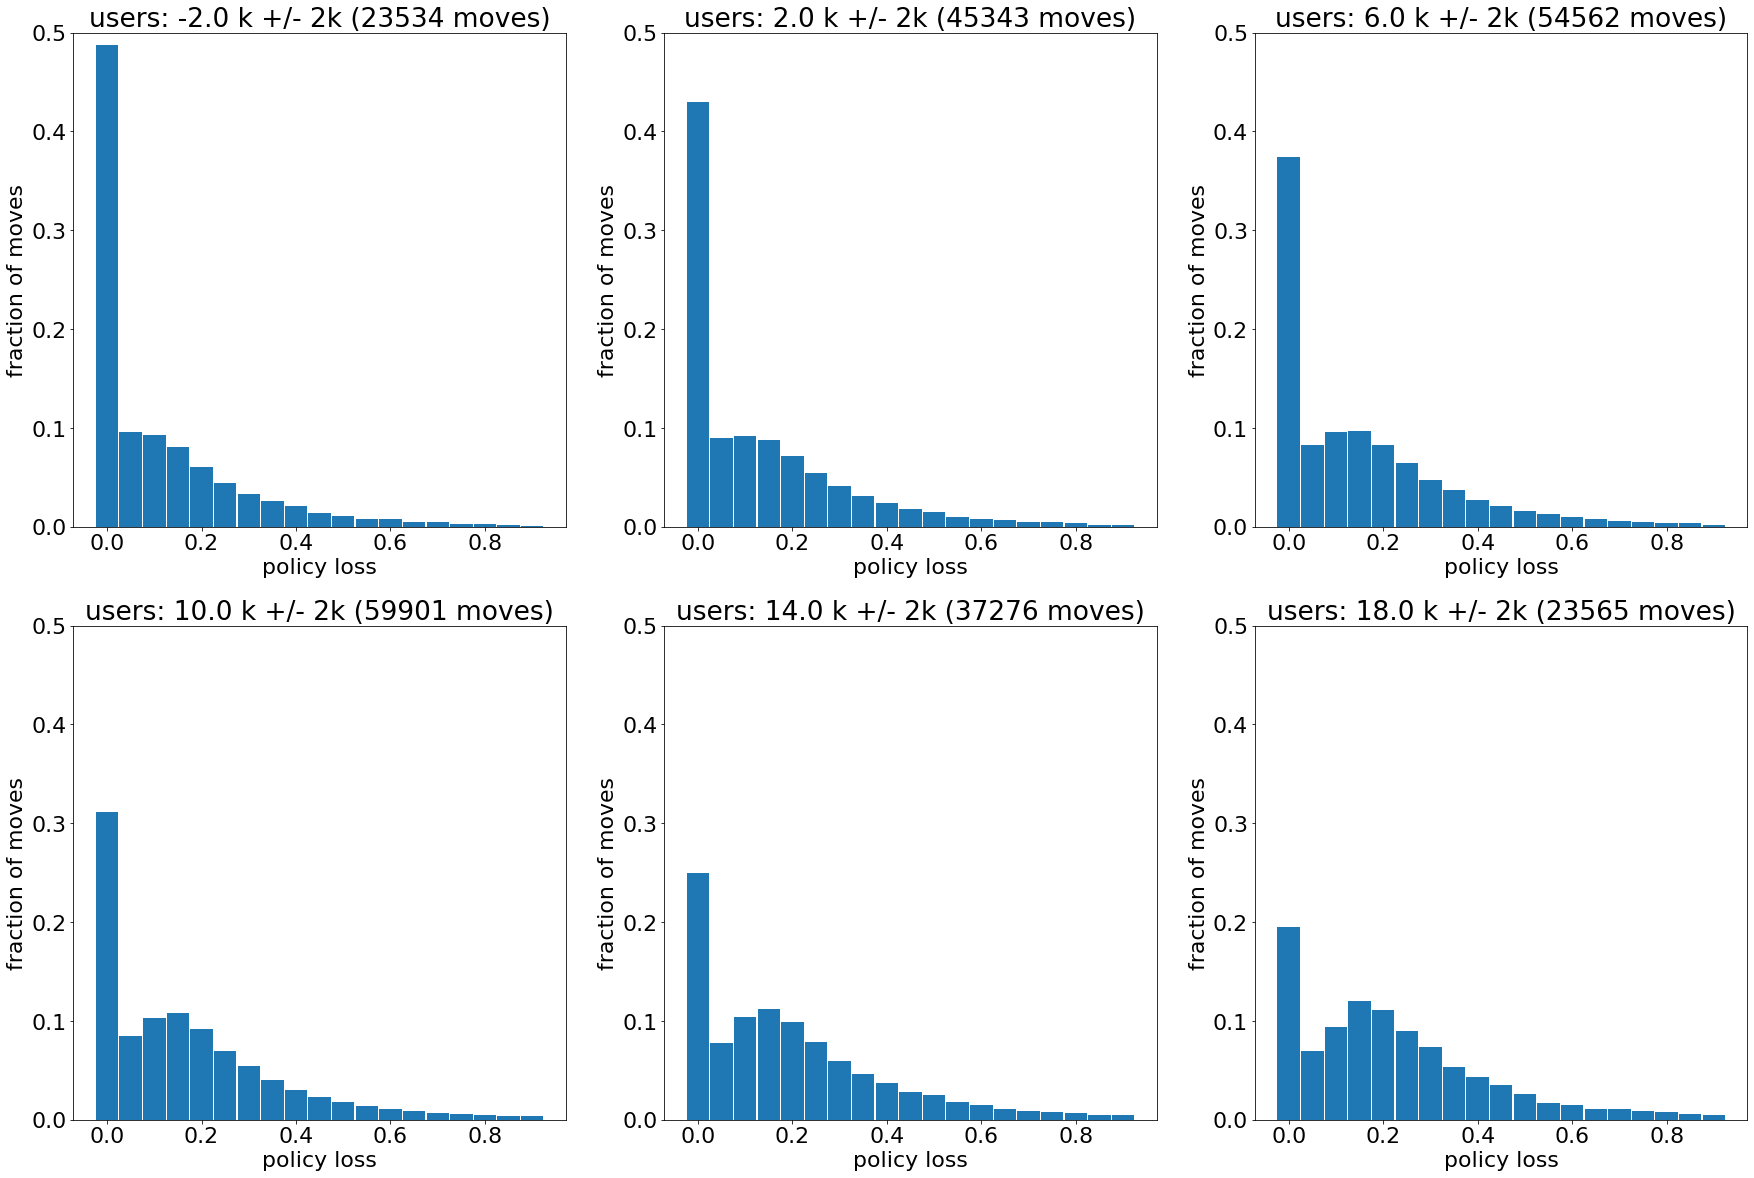

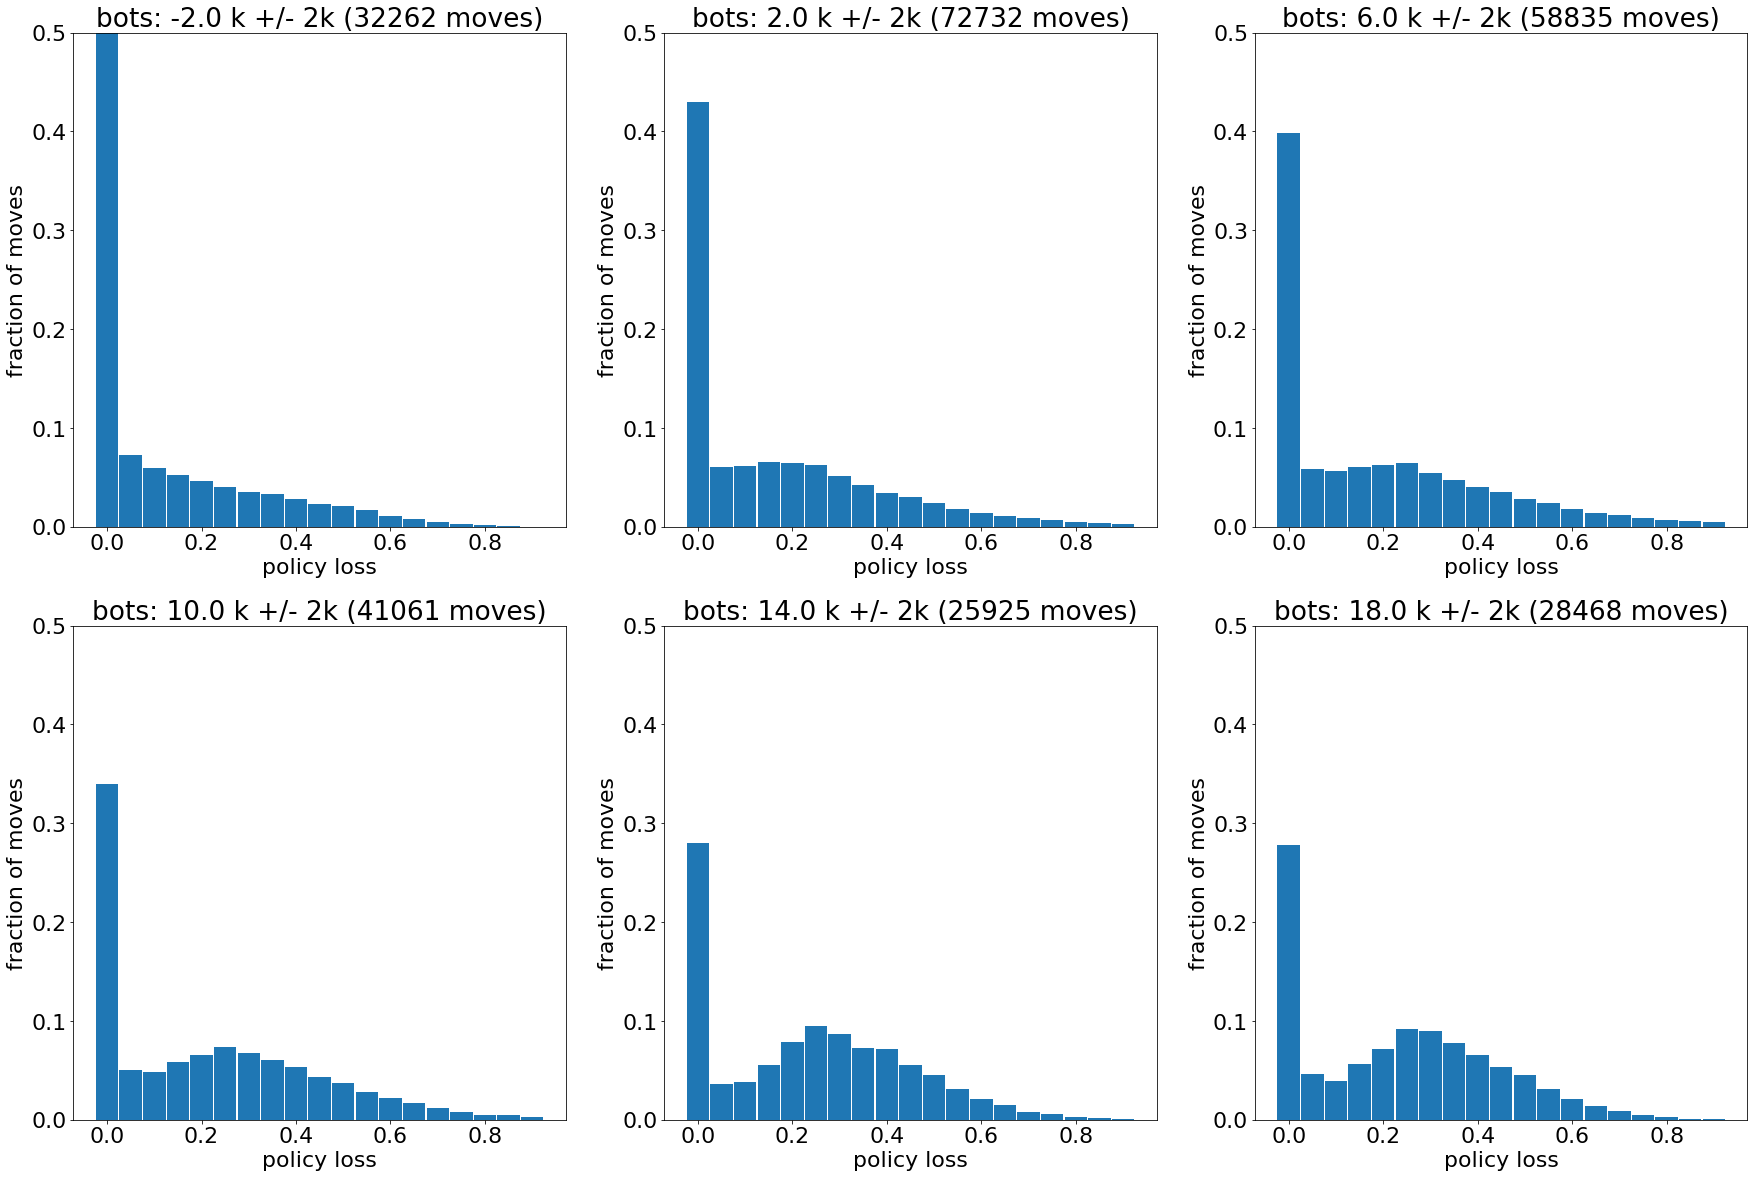

In [16]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05),rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('policy loss')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

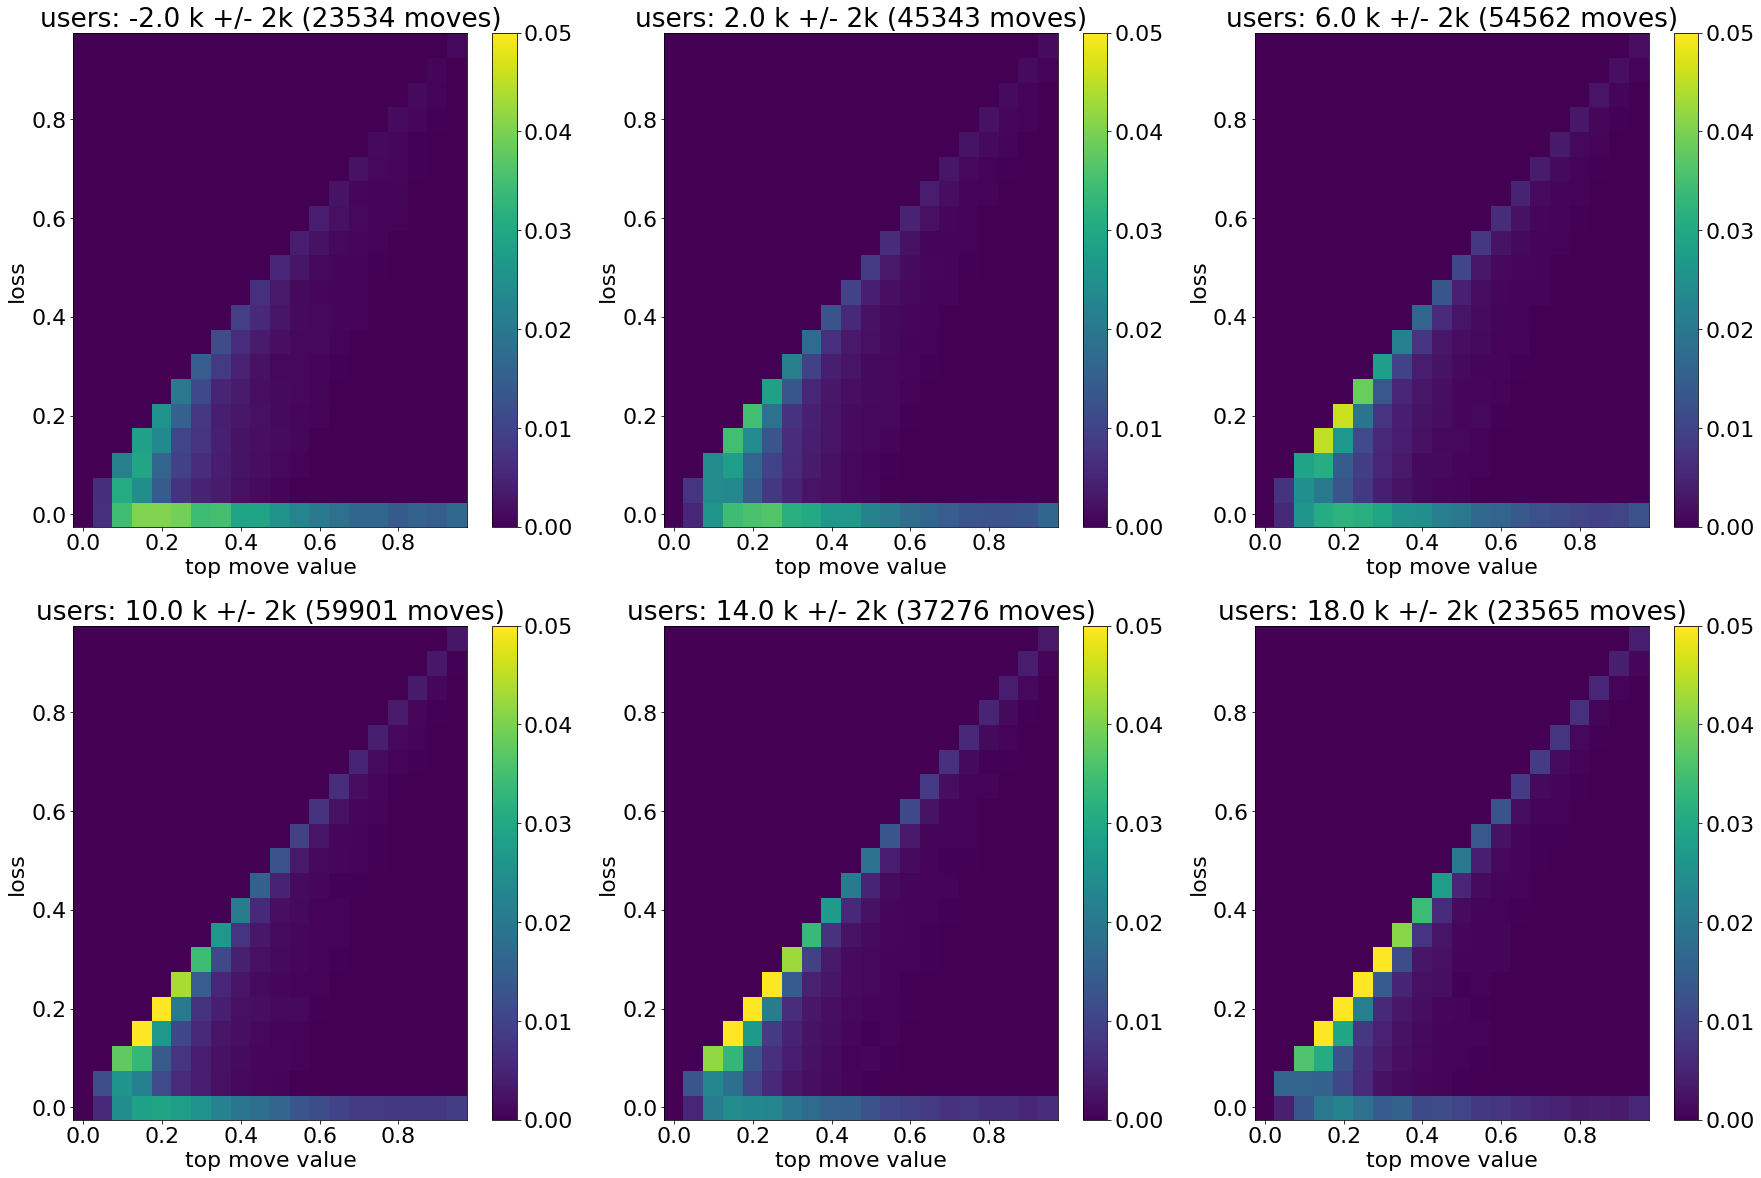

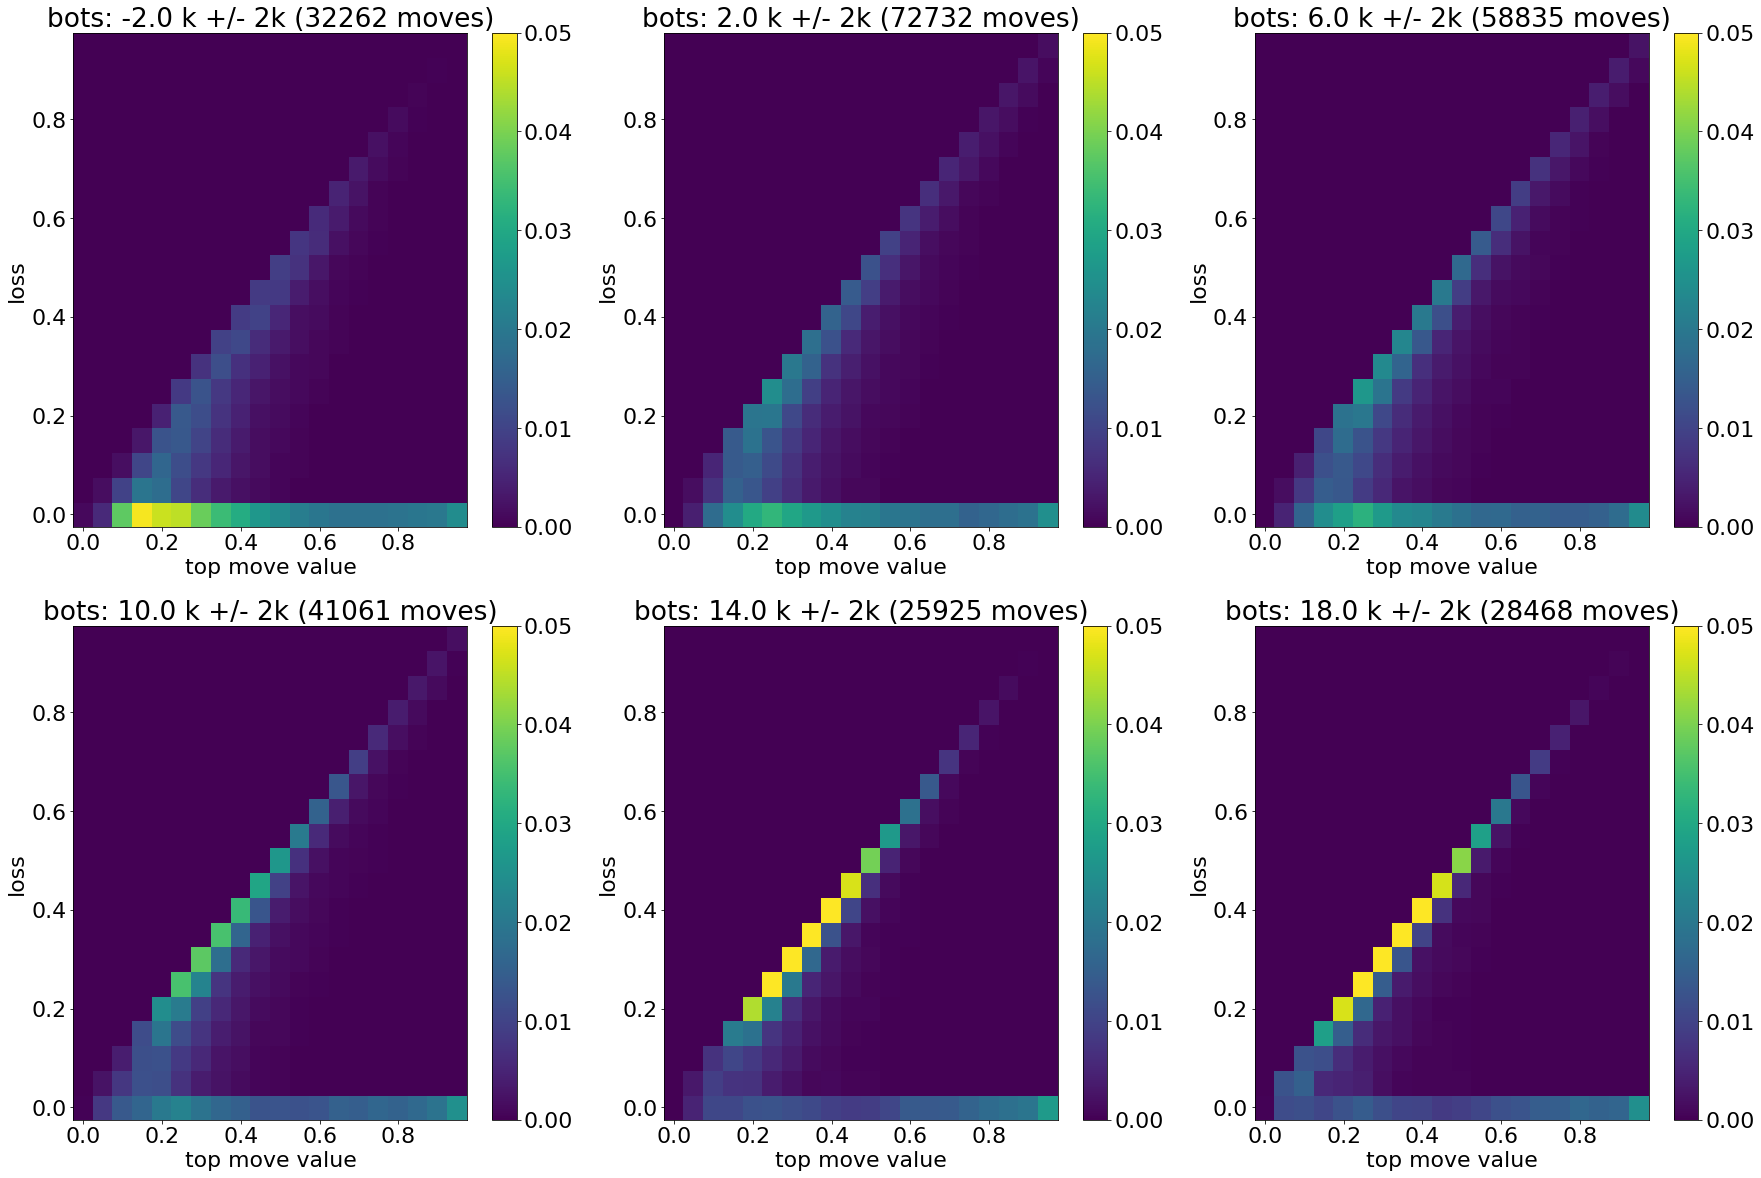

In [17]:
bins = np.arange(-0.025,1.025,0.05)
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        weights = np.ones_like(df.top_value) / len(df.top_value)
        plt.hist2d(df.top_value, df.top_value - df.policy_value,
                            bins=[bins,bins],weights=weights,vmin=0, vmax=0.05)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('top move value')
        plt.ylabel('loss')
        plt.colorbar()

Text(0.5, 1.0, 'bot moves top policy value')

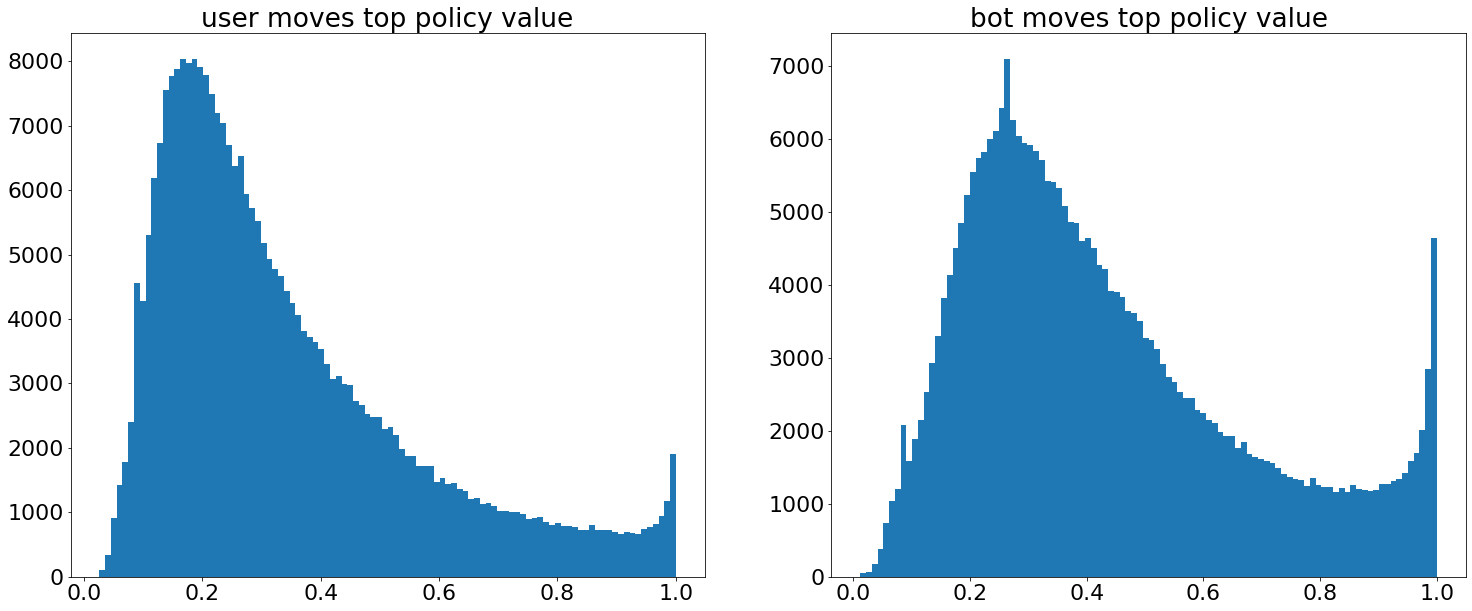

In [18]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1); plt.hist(user_moves.top_value,bins=100); plt.title('user moves top policy value')
plt.subplot(1,2,2); plt.hist(bot_moves.top_value,bins=100); plt.title('bot moves top policy value')

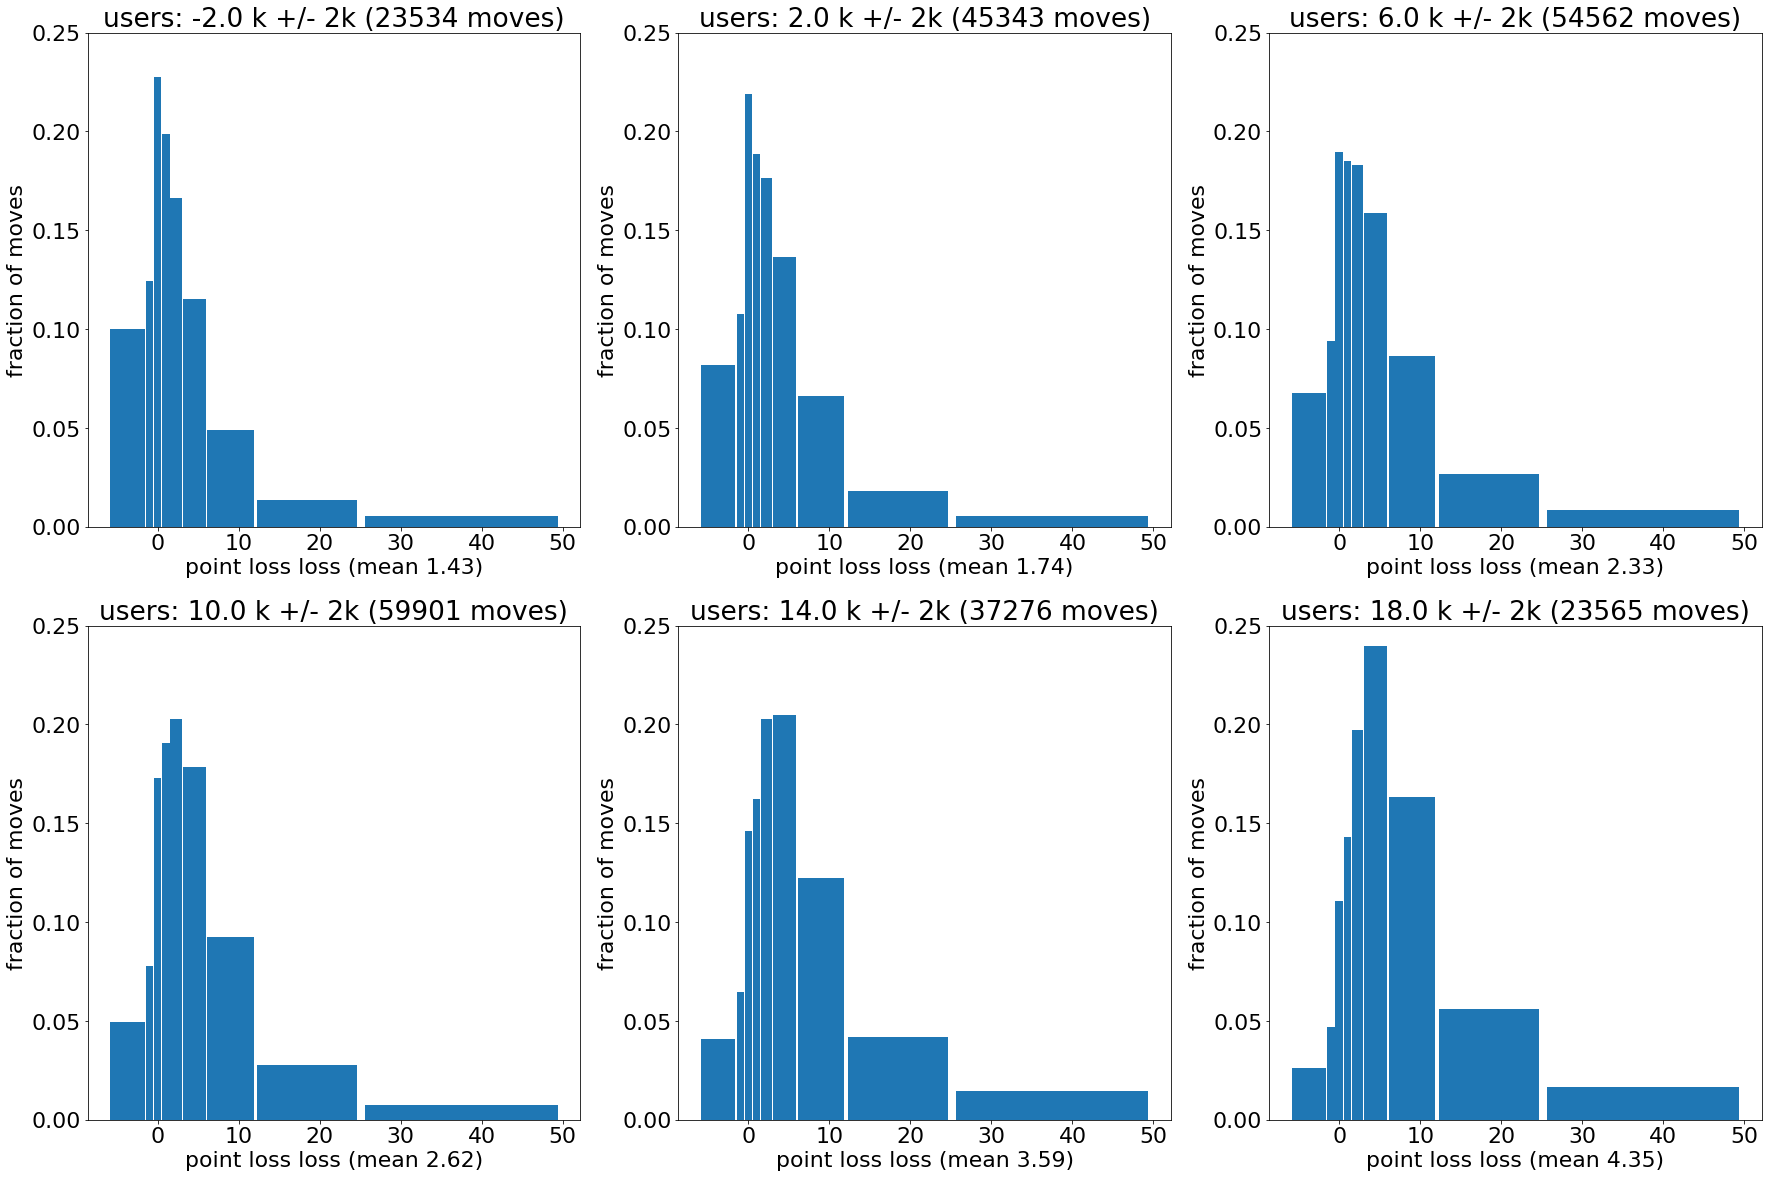

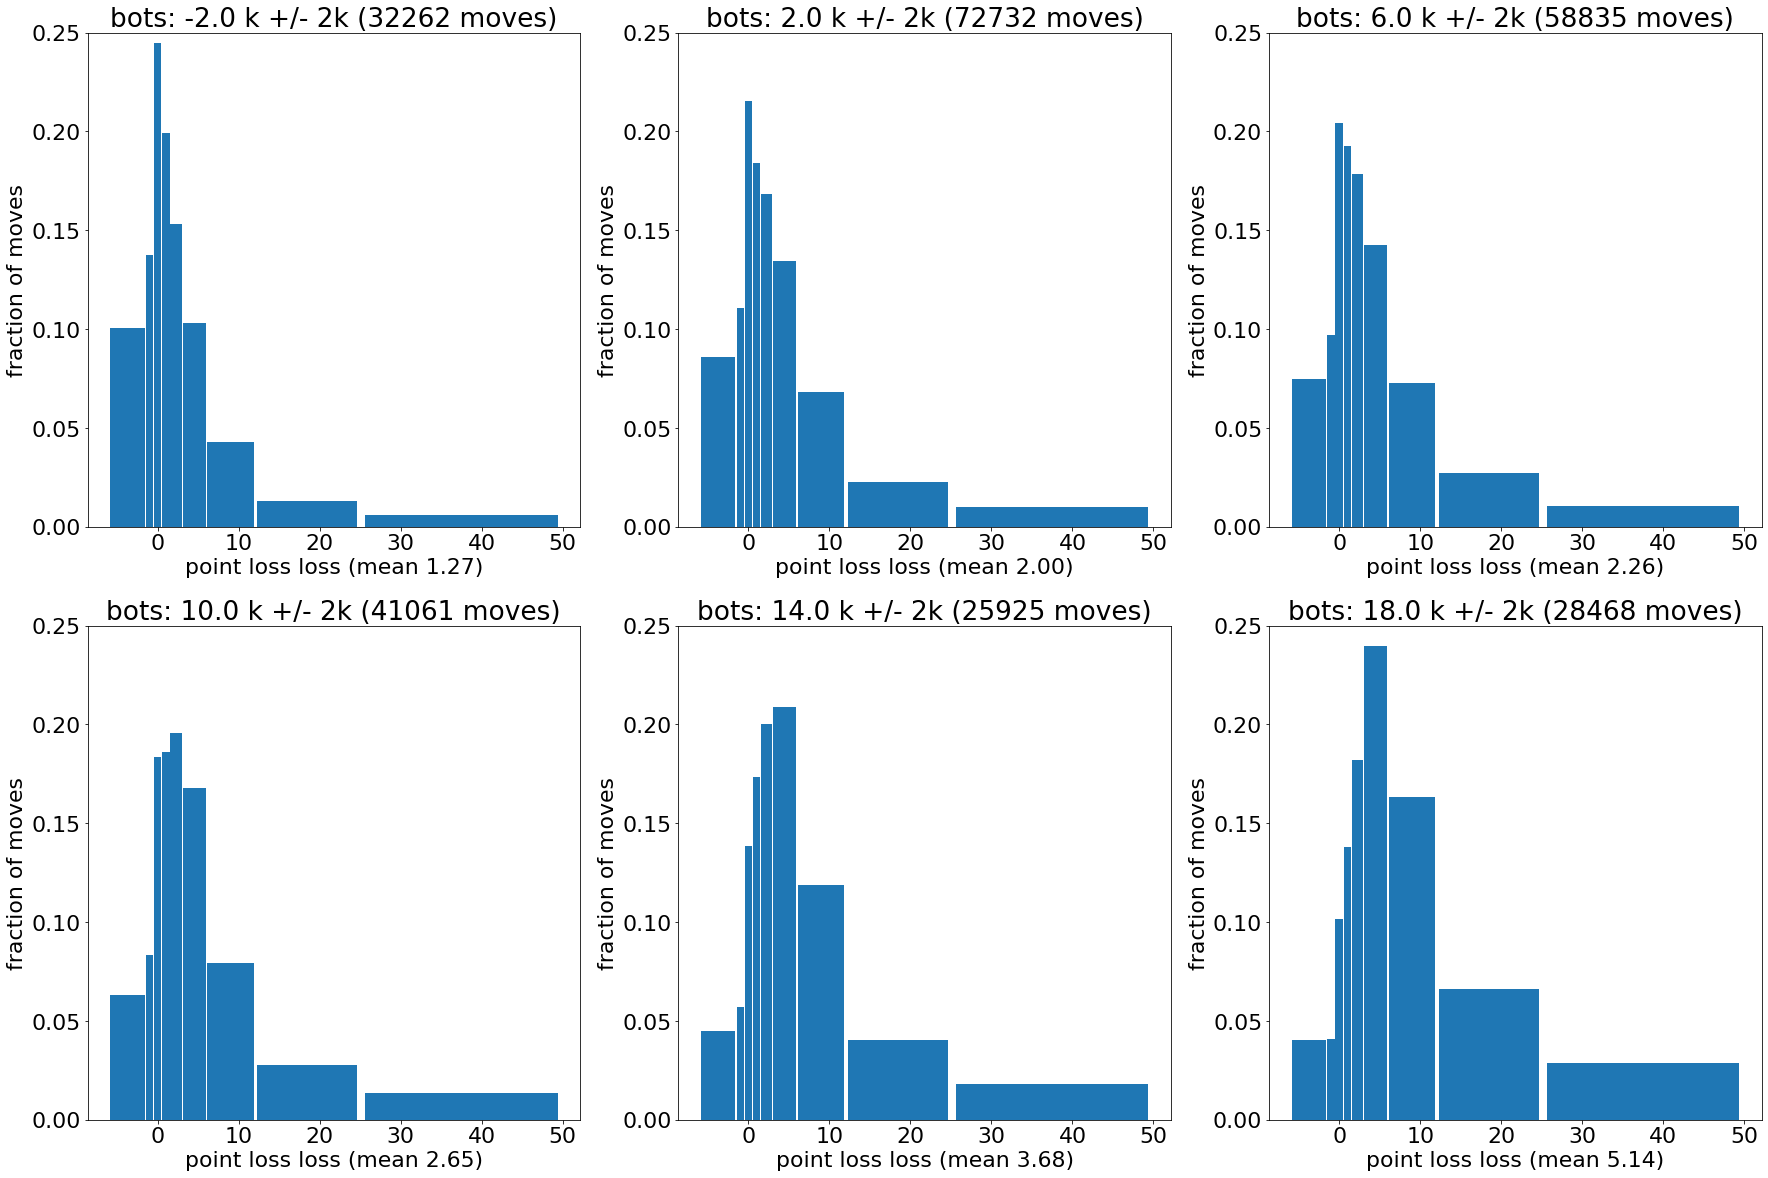

In [19]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel(f"point loss loss (mean {df.points_lost.mean():.2f})")
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.25])

In [ ]:
## Really weird case where a 25k game has a bunch of -60pt moves

In [20]:
user_moves.loc[user_moves.points_lost < -55]

,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
5354,24669182,188,178,0,0.206659,0.206659,-42.356144,-66.278280,white,white,13.547656
8929,24670494,265,111,1,0.286134,0.340086,16.826719,-78.887503,black,black,16.967545
21137,24688492,351,85,0,0.189031,0.189031,0.617875,-56.310739,black,black,27.830007
21139,24688492,353,83,0,0.517165,0.517165,20.666153,-73.848595,black,black,27.830007
21147,24688492,361,77,0,0.313270,0.313270,3.695175,-60.350982,black,black,27.830007
...,...,...,...,...,...,...,...,...,...,...,...
545291,24673604,152,214,0,0.509788,0.509788,-17.478998,-76.902018,white,white,-4.514790
558958,24609031,257,124,0,0.479699,0.479699,43.947533,-64.014694,black,black,12.250499
563822,24592922,214,156,2,0.065460,0.158675,-24.697437,-56.315954,white,white,14.641963
569529,24698412,303,102,0,0.666490,0.666490,21.657320,-56.883627,black,black,4.576171


In [42]:
filename = games_data.loc[24688492].file

In [72]:
e_config["max_visits"] = e_config["fast_visits"] = 1
sgf = KaTrainSGF.parse_file(filename)
game = Game(kt, engine, move_tree=sgf)
game.redo(999)
nodes = game.current_node.nodes_from_root

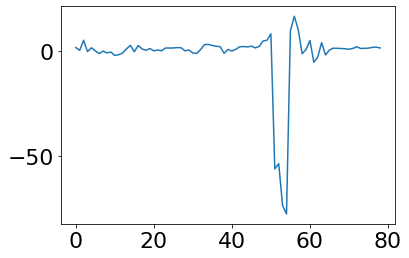

In [75]:
sc = [n.score for n in nodes]
pl = [n.points_lost for n in nodes]
plt.plot(pl[300:])

In [77]:
e_config["max_visits"] = e_config["fast_visits"] = 25
game = Game(kt, engine, move_tree=sgf)
game.redo(999)
nodes25 = game.current_node.nodes_from_root

In [78]:
sc25 = [n.score for n in nodes25]
pl25 = [n.points_lost for n in nodes25]

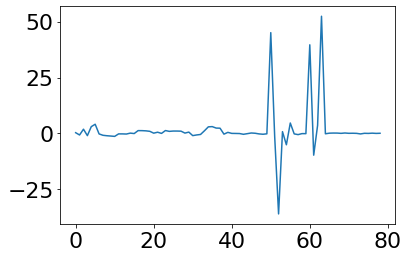

In [79]:
plt.plot(pl25[300:])